In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#Creating the inspector and finding the column names
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
last_date_string = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date_string,"%Y-%m-%d")
last_date
one_year_back = last_date - dt.timedelta(days=365)
one_year_back

datetime.datetime(2016, 8, 23, 0, 0)

In [13]:
# Perform a query to retrieve the data and precipitation scores

precipitation_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_back)

# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df = pd.DataFrame(precipitation_results)
prec_df = prec_df.set_index('date')

# Sort the dataframe by date
prec_df = prec_df.sort_index(axis=0)

# Use Pandas Plotting with Matplotlib to plot the data
prec_df.head(15)

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


Text(0.5, 0, 'Date')

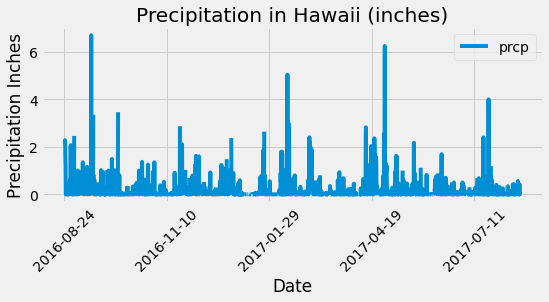

In [14]:
chart = prec_df.plot(use_index=True, rot=45, legend=True, title="Precipitation in Hawaii (inches)", figsize=(8,3))
chart.set_ylabel("Precipitation Inches")
chart.set_xlabel("Date")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
#Creating the inspector and finding the column names
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_stats = session.query(Station.id, func.count(Station.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Station.id).\
    order_by(func.count(Station.id).desc()).all()
station_stats

[(7, 2772),
 (1, 2724),
 (2, 2709),
 (6, 2669),
 (9, 2612),
 (3, 2202),
 (8, 1979),
 (4, 1372),
 (5, 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

low_temp_result = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).first()

high_temp_result = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).all()

avg_temp_result = session.query(func.avg(Measurement.tobs)).\
    filter(Station.id == 7).all()

low_temp = np.ravel(low_temp_result)
high_temp = np.ravel(high_temp_result)
avg_temp = np.ravel(avg_temp_result)

print(f'The lowest temperature for Station 7 is {low_temp[0]}')
print(f'The highest temperature for Station 7 is {high_temp[0]}')
print(f'The average temperature for Station 7 is {round(avg_temp[0],2)}')


The lowest temperature for Station 7 is 54.0
The highest temperature for Station 7 is 85.0
The average temperature for Station 7 is 73.1


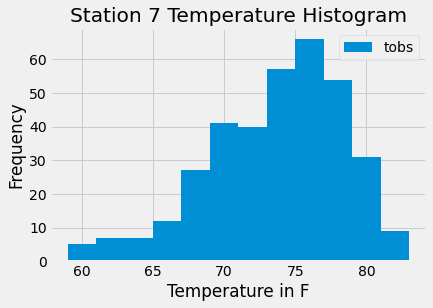

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date_string = session.query(Measurement.date).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).\
    order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date_string,"%Y-%m-%d")
last_date
one_year_back = last_date - dt.timedelta(days=365)
one_year_back

temp_results = session.query(Measurement.tobs).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).\
    filter(Measurement.date > one_year_back)
    
temp_df = pd.DataFrame(temp_results)

temp_chart = temp_df.plot(kind='hist',bins=12, title="Station 7 Temperature Histogram")
temp_chart.set_xlabel('Temperature in F')
temp_chart

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
